In [1]:
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from utils import *

# Init data sizes and parametes of the PXM of ID16A

In [2]:
th="3920"
path = f'/data/visitors/danmax/20241507/2025060408/viktor/ca_{th}/'
with  h5py.File(f'{path}/data_ca.h5','r') as fid:
    data = fid[f'/exchange/data'][:].astype('float32')
    ref = fid[f'/exchange/data_white'][:].astype('float32')
    dark = fid[f'/exchange/data_dark'][:].astype('float32')

    z1 = fid['/exchange/z1'][0]
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]
    focusToDetectorDistance = fid['/exchange/focusdetectordistance'][0]
    energy = fid['/exchange/energy'][0]
print(data.shape)


(225, 2048, 2048)


In [3]:
wavelength = 1.24e-09/energy  # [m] wave length
# focusToDetectorDistance = 1.28  # [m]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnification)  # object voxel size


# Pre-processing

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


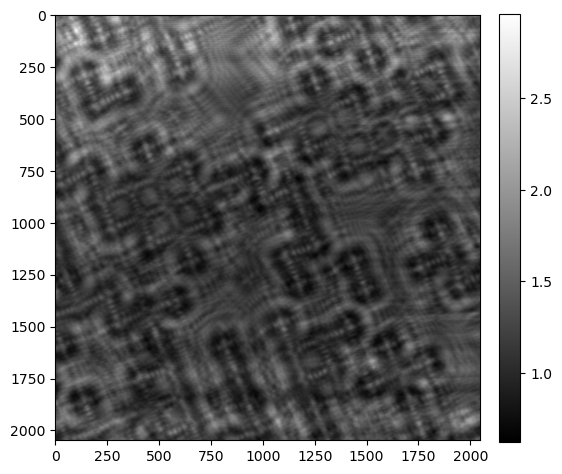

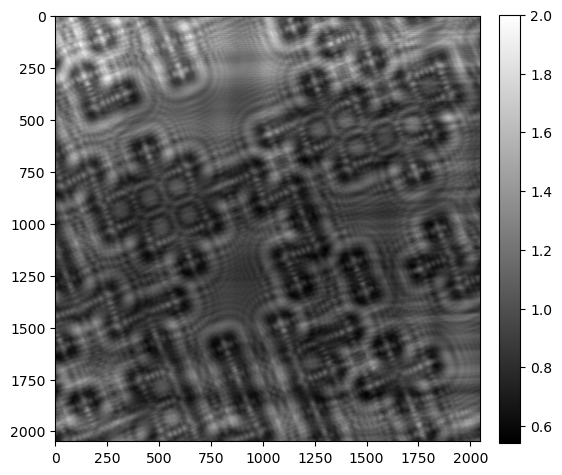

In [4]:
import cupyx.scipy.ndimage as ndimage
def remove_outliers(data, dezinger, dezinger_threshold):    
    res = data.copy()
    w = [dezinger,dezinger]
    for k in range(data.shape[0]):
        data0 = cp.array(data[k])
        fdata = ndimage.median_filter(data0, w)
        print(np.sum(np.abs(data0-fdata)>fdata*dezinger_threshold))
        res[k] = np.where(np.abs(data0-fdata)>fdata*dezinger_threshold, fdata, data0).get()
    return res

dark = np.mean(dark,axis=0)
ref = np.mean(ref,axis=0)
data -= dark
ref -= dark

data[data<0]=0
ref[ref<0]=0
# data[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = data[:,1280//3:1280//3+25//3,890//3:890//3+25//3]
# ref[1320//3:1320//3+25//3,890//3:890//3+25//3] = ref[1280//3:1280//3+25//3,890//3:890//3+25//3]

data = remove_outliers(data, 3, 0.8)    
ref = remove_outliers(ref[None], 3, 0.8)[0]     

data /= np.mean(ref)
ref /= np.mean(ref)

data[np.isnan(data)] = 1
ref[np.isnan(ref)] = 1

mshow(data[0],mshow)
mshow(ref,mshow)

# find shift with 1 pixel accuracy

In [5]:
# back to original shape
# original shape is bad, adjust it
# scan goes from top left!
# shifts = np.loadtxt(f'/data/vnikitin/ESRF/ID16A/20240924/positions/shifts_code_nfp18x18ordered.txt')[:,::-1]
# shifts[:,1]*=-1
# shifts = shifts/voxelsize*1e-6
# print(shifts[:4])

In [6]:
ids = np.arange(225)
for k in range(15):    
    if k%2==1:
        ids[k*15:(k+1)*15] = ids[k*15:(k+1)*15][::-1]
data=data[ids]
print(data.shape)

(225, 2048, 2048)


In [7]:

[npos,n] = data.shape[:2]
shifts_relative = np.zeros([npos,2])#shifts*0

def my_phase_corr(d1, d2):
    image_product = np.fft.fft2(d1) * np.fft.fft2(d2).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    ind = np.unravel_index(np.argmax(cc_image.real, axis=None), cc_image.real.shape)
    shifts = np.subtract(ind,d1.shape[-1]//2)
    return shifts

def S(psi,p):
    """Subpixel shift"""
    psi=cp.array(psi)
    p=cp.array(p)
    n = psi.shape[-1]
    x =cp.fft.fftfreq(2*n).astype('float32')
    [y, x] = cp.meshgrid(x, x)
    psi = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)))
    pp = np.exp(-2*np.pi*1j * (y*p[:, 1, None, None]+x*p[:, 0, None, None])).astype('complex64')
    res = np.fft.ifft2(pp*np.fft.fft2(psi))

    res = res[:,n//2:-n//2,n//2:-n//2]
    return res.get()

rdata = data/(ref+1e-6)
rdatat = rdata.copy()    
for k in range(0,npos-1):         
    shifts_relative[k] = my_phase_corr(rdata[k],rdata[k+1])
    rdatat[k:k+1] = S(rdata[k:k+1].astype('complex64'),-shifts_relative[k:k+1]).real
    dif = rdatat[k]-rdatat[k+1]
    # mshow(dif,True)
    nn = np.linalg.norm(dif[n//2-n//16:n//2+n//16,n//2-n//16:n//2+n//16])
    if nn>80:
        print('WARNING')
        mshow(dif,True,vmax=1,vmin=-1)
    print(k,shifts_relative[k],nn)    


0 [  27. -120.] 12.459039
1 [  0. -98.] 10.839593
2 [  18. -186.] 11.273446
3 [-18. -54.] 11.251332
4 [ 15. -80.] 12.70754
5 [ -40. -128.] 11.95185
6 [  77. -175.] 11.173227
7 [-79. -30.] 10.783324
8 [ 40. -96.] 10.958141
9 [-35. -93.] 11.727865
10 [  35. -167.] 11.295943
11 [ 44. -78.] 11.022476
12 [ -59. -100.] 12.167738
13 [  16. -122.] 13.170538
14 [-146.   22.] 12.473789
15 [64. 53.] 11.497594
16 [  5. 124.] 11.644779
17 [-8. 74.] 10.86807
18 [-46. 170.] 12.006422
19 [ 12. 116.] 11.919398
20 [-2. 52.] 11.295973
21 [60. 50.] 11.417755
22 [-22. 177.] 11.426504
23 [ 11. 147.] 11.722223
24 [21. 31.] 11.054484
25 [-20. 176.] 11.38795
26 [-37.  51.] 12.416589
27 [-24. 164.] 12.774493
28 [17. 69.] 12.736926
29 [-121.  -24.] 12.02901
30 [ 74. -48.] 10.479489
31 [ -30. -136.] 11.175516
32 [ 18. -30.] 11.029426
33 [ -18. -172.] 10.804071
34 [   8. -152.] 10.222026
35 [-18. -28.] 10.4073715
36 [   8. -152.] 10.954508
37 [  1. -79.] 10.655837
38 [  38. -182.] 10.948989
39 [-23.  -5.] 10.43617

[[ 737. -150.]
 [ 701.  -20.]
 [ 754.   32.]
 [ 746.   84.]
 [ 806.  223.]
 [ 724.  392.]
 [ 806.  466.]
 [ 788.  588.]
 [ 780.  690.]
 [ 726.  840.]]


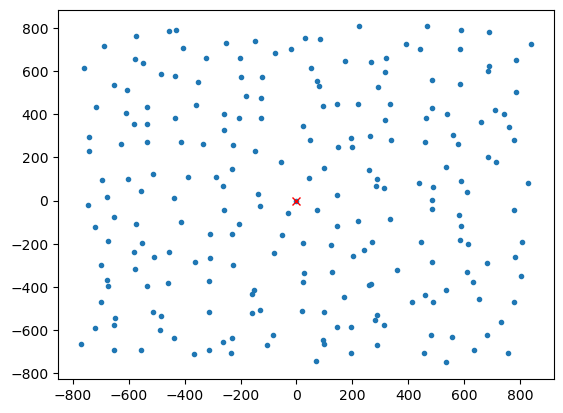

In [8]:
ipos = npos//2# align wrt the middle
shifts_new = shifts_relative*0
for k in range(ipos):
    shifts_new[k] = np.sum(shifts_relative[k:ipos],axis=0) 
shifts_new[ipos] = 0#shifts[ipos]
for k in range(ipos,npos):
    shifts_new[k] = np.sum(-shifts_relative[ipos:k],axis=0)


# print(shifts[-10:])
print(shifts_new[-10:])
# plt.plot(shifts[:,1],shifts[:,0],'.')
plt.plot(shifts_new[:,1],shifts_new[:,0],'.')
plt.plot(shifts_new[ipos,1],shifts_new[ipos,0],'rx')
plt.show()

np.save('shifts_new.npy',shifts_new)


In [9]:
# shifts_new=shifts_new[ids]

In [10]:
path_out = f'/data/visitors/danmax/20241507/2025060408/viktor/ca_{th}/'
with  h5py.File(f'{path_out}/data_ca.h5','a') as fid:
    try:
        del fid[f'/exchange/shifts']
        del fid[f'/exchange/pdata']
        del fid[f'/exchange/pref']
    except:
        pass
    fid.create_dataset(f'/exchange/shifts',data=shifts_new)     
    fid.create_dataset(f'/exchange/pdata',data=data)     
    fid.create_dataset(f'/exchange/pref',data=ref)     

In [11]:
shifts_new

array([[-666., -772.],
       [-693., -652.],
       [-693., -554.],
       [-711., -368.],
       [-693., -314.],
       [-708., -234.],
       [-668., -106.],
       [-745.,   69.],
       [-666.,   99.],
       [-706.,  195.],
       [-671.,  288.],
       [-706.,  455.],
       [-750.,  533.],
       [-691.,  633.],
       [-707.,  755.],
       [-561.,  733.],
       [-625.,  680.],
       [-630.,  556.],
       [-622.,  482.],
       [-576.,  312.],
       [-588.,  196.],
       [-586.,  144.],
       [-646.,   94.],
       [-624.,  -83.],
       [-635., -230.],
       [-656., -261.],
       [-636., -437.],
       [-599., -488.],
       [-575., -652.],
       [-592., -721.],
       [-471., -697.],
       [-545., -649.],
       [-515., -513.],
       [-533., -483.],
       [-515., -311.],
       [-523., -159.],
       [-505., -131.],
       [-513.,   21.],
       [-514.,  100.],
       [-552.,  282.],
       [-529.,  287.],
       [-470.,  414.],
       [-470.,  489.],
       [-45